# régression linéaire multiple

## Introduction  

La régression linéaire multiple est une méthode statistique qui permet d'étudier et de modéliser la relation entre une variable dépendante (ou cible) et plusieurs variables explicatives (ou prédictrices). Elle est particulièrement utile pour comprendre comment différents facteurs contribuent simultanément à un phénomène observé.  

Dans le contexte de la transition énergétique, une question clé est de savoir quels sont les facteurs économiques et sociaux qui influencent le pourcentage d'énergie renouvelable dans le mix énergétique des pays. Cette problématique est cruciale pour aider les décideurs à concevoir des politiques efficaces pour encourager l’adoption des énergies renouvelables.  

#### Problématique  
Quels sont les déterminants économiques et sociaux qui influencent la proportion d'énergies renouvelables dans le mix énergétique des pays, et dans quelle mesure ces facteurs interagissent-ils pour façonner la transition énergétique ?  

#### Variables utilisées  
1. **Variable cible (dépendante)** :  
   - Pourcentage d'énergie renouvelable dans le mix énergétique (**EG.FEC.RNEW.ZS**).  

2. **Variables explicatives (indépendantes)** :  
   - **PIB par habitant** (**NY.GDP.PCAP.CD**) : indicateur économique reflétant le niveau de développement économique d’un pays.  
   - **Investissements dans les énergies renouvelables** (**EG.ELC.RNWX.ZS**) : pourcentage du PIB investi dans les énergies renouvelables.
   - **Accès à l'électricité (% de la population)** (**EG.ELC.ACCS.ZS**) : Reflète le niveau d'infrastructure énergétique.  

#### Objectifs de l'étude  
1. **Analyser l'impact des variables explicatives** sur la proportion d'énergie renouvelable dans le mix énergétique.  
2. **Quantifier l'effet de chaque facteur** pour déterminer les leviers les plus efficaces dans la transition énergétique.  
3. **Proposer des recommandations politiques** pour renforcer l'adoption des énergies renouvelables.

## Étape 1 : Importation des bibliothèques nécessaires

In [64]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as mb
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from sklearn import metrics
from sklearn.metrics import r2_score
from scipy.stats import norm

## Étape 2 : Chargement et exploration des données

In [65]:
data = pd.read_csv('transition_energetique_pays_2023.csv')

In [66]:
# Affichage des premières lignes
print(data.head())

                          Pays  Taux d'énergie renouvelable  Année  \
0                  Afghanistan                    17.846154   2023   
1  Africa Eastern and Southern                    62.614134   2023   
2   Africa Western and Central                    77.223132   2023   
3                      Albania                    39.283333   2023   
4                      Algeria                     0.150000   2023   

   Investissements en énergies renouvelables (% du PIB)  \
0                                           4.838663      
1                                           1.346697      
2                                           0.335375      
3                                           0.000000      
4                                           0.018654      

   PIB par habitant (USD)  Taux de scolarisation secondaire (%)  \
0              415.707417                             47.154018   
1             1659.515290                             69.520690   
2             1568.7243

In [67]:
# Vérification des colonnes et des types de données
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 10 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Pays                                                  266 non-null    object 
 1   Taux d'énergie renouvelable                           266 non-null    float64
 2   Année                                                 266 non-null    int64  
 3   Investissements en énergies renouvelables (% du PIB)  266 non-null    float64
 4   PIB par habitant (USD)                                266 non-null    float64
 5   Taux de scolarisation secondaire (%)                  266 non-null    float64
 6   Accès à l'électricité (%)                             266 non-null    float64
 7   Revenu                                                266 non-null    object 
 8   Dépassement 50%                                       266 no

## Étape 3 : Préparation des données

#### 1-Sélectionner les colonnes nécessaires.

In [68]:
data_regression = data[['Taux d\'énergie renouvelable', 'PIB par habitant (USD)', 
                                'Investissements en énergies renouvelables (% du PIB)', 
                                'Accès à l\'électricité (%)']]

#### 2-Vérifier la distribution des données.

In [69]:
# Vérification des statistiques descriptives
print(data_regression.describe())

       Taux d'énergie renouvelable  PIB par habitant (USD)  \
count                   266.000000              266.000000   
mean                     29.667803            19801.484066   
std                      27.240385            29241.462131   
min                       0.000000              193.007146   
25%                       7.401923             2478.681863   
50%                      21.750203             8142.831461   
75%                      46.682692            23249.998705   
max                      95.833333           256580.515123   

       Investissements en énergies renouvelables (% du PIB)  \
count                                         266.000000      
mean                                            4.838663      
std                                             6.285018      
min                                             0.000000      
25%                                             0.569904      
50%                                             4.838663      


1. **Taux d'énergie renouvelable** :
   - Moyenne : ~29.67%, avec une forte variabilité (écart-type ~27.24%).
   - Large amplitude : de 0% (aucune énergie renouvelable) à 95.83% (quasi-totalité).
   - **Conclusion** : Les pays présentent des niveaux très hétérogènes de transition énergétique.

2. **PIB par habitant (USD)** :
   - Moyenne : ~19,801 USD, mais une grande disparité (écart-type ~29,241 USD).
   - Écarts extrêmes : ~193 USD (pays pauvres) à ~256,580 USD (pays riches).
   - **Conclusion** : Le développement économique varie fortement entre les pays.

3. **Investissements en énergies renouvelables (% du PIB)** :
   - Moyenne : ~ 4.84%, avec un écart-type élevé (~6.29%).
   - Concentration autour de la médiane (~ 4.84%) et certains pays atteignent des pics (~47.94%).
   - **Conclusion** : Les investissements restent modestes pour beaucoup de pays, mais certains se démarquent.

4. **Accès à l'électricité (%)** :
   - Moyenne : ~83.58%, mais des écarts importants (écart-type ~25.29%).
   - Large gamme : 5.12% (infrastructures faibles) à 100% (infrastructures complètes).
   - **Conclusion** : Bien que l’accès à l’électricité soit globalement élevé, certains pays ont encore un déficit important.

## Étape 4 : Analyse exploratoire

#### 1-visualiser les relations entre les variables explicatives et la variable cible

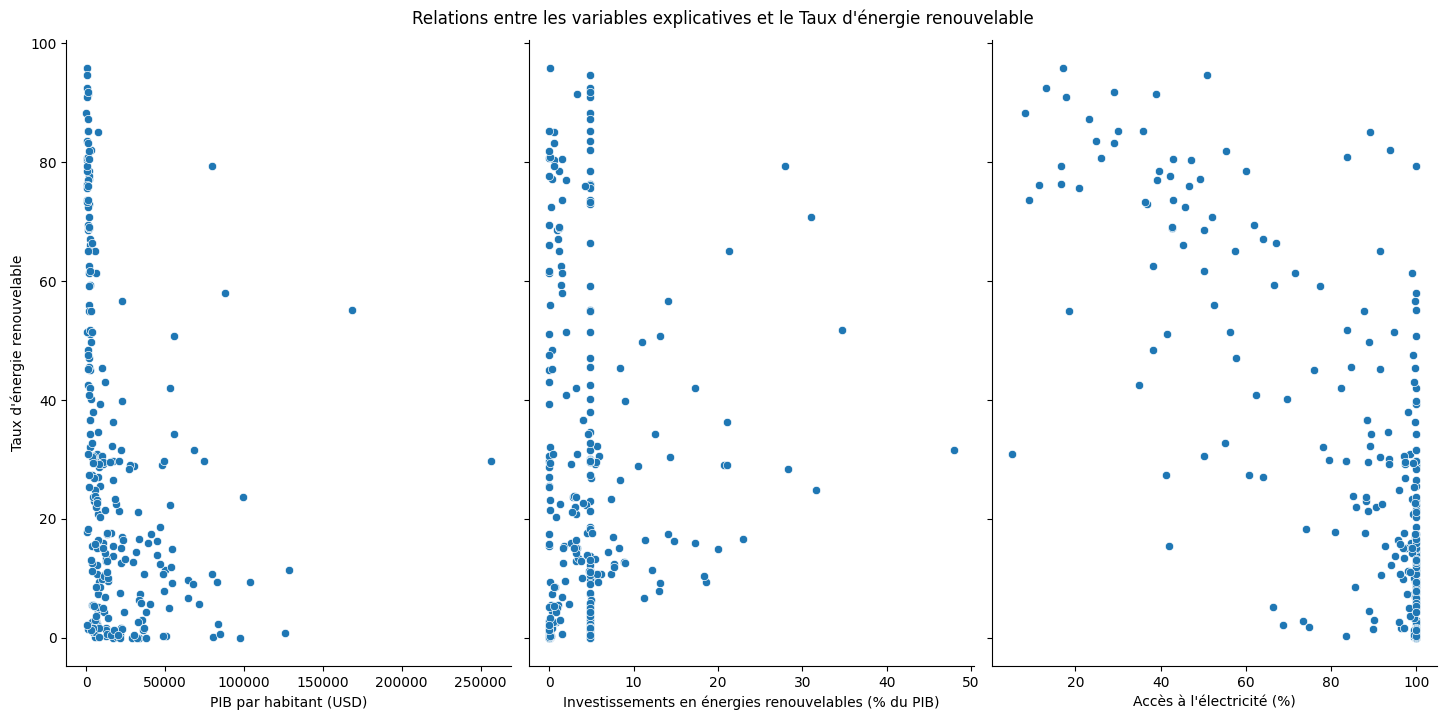

In [70]:
# Créer un pairplot pour visualiser les relations entre les variables explicatives et la variable cible
sns.pairplot(
    data_regression,
    x_vars=[
        "PIB par habitant (USD)", 
        "Investissements en énergies renouvelables (% du PIB)", 
        "Accès à l'électricité (%)"
    ],
    y_vars="Taux d'énergie renouvelable",
    height=7,
    aspect=0.7
)

plt.suptitle("Relations entre les variables explicatives et le Taux d'énergie renouvelable", y=1.02)
plt.show()

voici une interprétation des relations entre les variables explicatives et **la variable cible (Taux d'énergie renouvelable)** :

##### 1. **PIB par habitant (USD)** :
- La majorité des pays ayant un taux élevé d'énergie renouvelable ont un PIB par habitant relativement faible (en dessous de 50 000 USD). 
- Une tendance inverse peut être perçue : plus le PIB par habitant augmente, plus le taux d'énergie renouvelable tend à diminuer. Cependant, cette relation semble très dispersée.

##### 2. **Investissements en énergies renouvelables (% du PIB)** :
- Il semble y avoir une corrélation légèrement positive : certains pays avec des investissements plus élevés en pourcentage du PIB tendent à avoir des taux d'énergie renouvelable élevés.
- Cependant, la plupart des données sont concentrées autour de faibles pourcentages d'investissements, et la relation reste peu marquée.

##### 3. **Accès à l'électricité (%)** :
- Une majorité de points se situent dans la région où l'accès à l'électricité est proche de 100 %. Cela montre que de nombreux pays dans l'ensemble de données ont une bonne couverture électrique.
- Une relation inverse semble exister : les pays avec un taux d'accès élevé à l'électricité tendent à avoir un taux d'énergie renouvelable plus faible.

#### 2-Matrice de corrélation

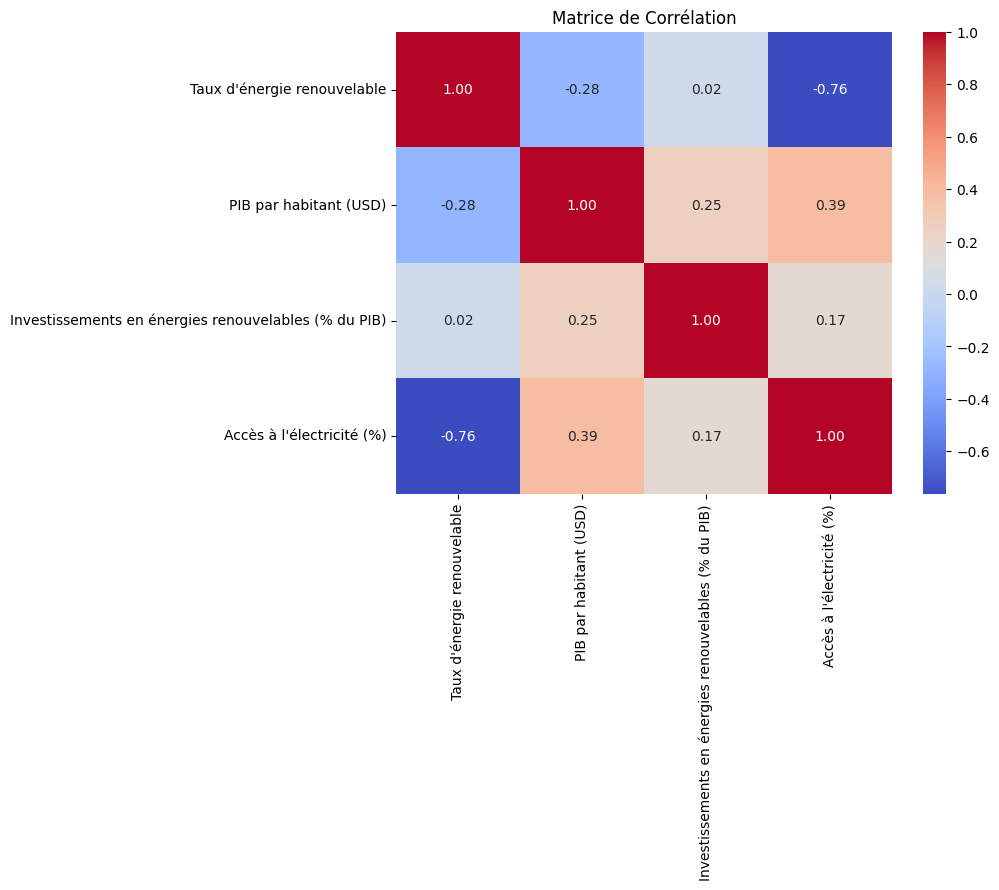

In [71]:
# Calcul de la matrice de corrélation
correlation_matrix = data_regression.corr()

# Affichage de la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de Corrélation")
plt.show()

##### Relations importantes
1. **Taux d'énergie renouvelable et Accès à l'électricité (%):**
   - Corrélation : **-0.76**
   - Interprétation : Forte corrélation négative. Cela signifie qu'à mesure que l'accès à l'électricité augmente, le taux d'énergie renouvelable tend à diminuer dans les données.

2. **Taux d'énergie renouvelable et PIB par habitant (USD):**
   - Corrélation : **-0.28**
   - Interprétation : Faible corrélation négative. Une augmentation du PIB par habitant est légèrement associée à une diminution du taux d'énergie renouvelable.

3. **Taux d'énergie renouvelable et Investissements en énergies renouvelables (% du PIB):**
   - Corrélation : **0.02**
   - Interprétation : La corrélation extrêmement faible (0.02). Les investissements en énergies renouvelables, en pourcentage du PIB, n'ont pas d'impact direct apparent sur le taux d'énergie renouvelable.


- **Taux d'énergie renouvelable** semble être fortement influencé par l'accès à l'électricité, mais moins par le PIB et les investissements en énergies renouvelables.

#### 3-Nuage de points

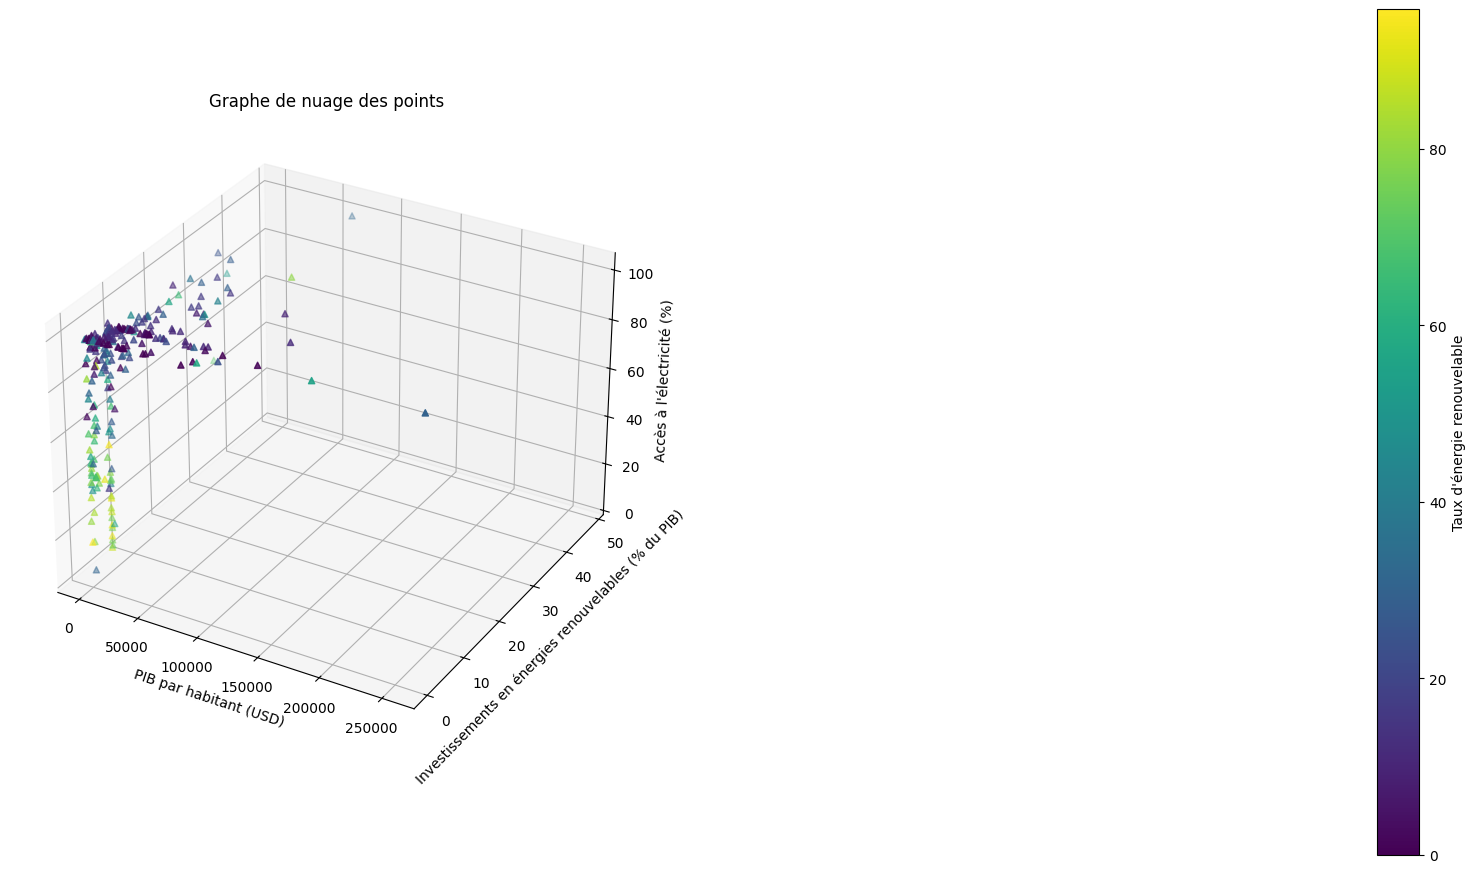

In [72]:
# 'x_vars' contient les 3 variables explicatives
# 'y_vars' contient la variable de réponse

# Créer un graphique de taille 16x10
grp = plt.figure(figsize=(40, 34))

# Ajouter un subplot 3D
ax = grp.add_subplot(121, projection='3d')

# Les variables explicatives
x = data_regression["PIB par habitant (USD)"]
y = data_regression["Investissements en énergies renouvelables (% du PIB)"]
z = data_regression["Accès à l'électricité (%)"]

# La variable de réponse (utilisée pour la couleur des points)
response = data_regression["Taux d'énergie renouvelable"]

# Créer le nuage de points en 3D
sc = ax.scatter(x, y, z, c=response, cmap='viridis', marker='^')

# Ajouter les labels aux axes
ax.set_xlabel('PIB par habitant (USD)')
ax.set_ylabel('Investissements en énergies renouvelables (% du PIB)')
ax.set_zlabel('Accès à l\'électricité (%)')

# Titre du graphique
plt.title('Graphe de nuage des points')

# Ajouter une barre de couleur pour indiquer les valeurs de la variable réponse
plt.colorbar(sc, label='Taux d\'énergie renouvelable', fraction=0.03, pad=0.52)

# Afficher le graphique
plt.show()

1. **Tendances générales** :
   - L’**accès à l’électricité** (axe Z) semble jouer un rôle majeur dans la variation du **taux d’énergie renouvelable**. Cela est cohérent avec la **corrélation négative forte (-0.76)** observée dans la matrice : les pays ayant un accès élevé à l’électricité tendent à utiliser des sources d’énergie moins renouvelables (probablement en raison d'une dépendance aux combustibles fossiles dans des systèmes électriques bien établis).

2. **Impact du PIB par habitant** :
   - Bien que le **PIB par habitant** varie fortement (axe X), sa relation avec le taux d’énergie renouvelable est **faiblement négative**. Les pays riches, bien qu’ayant des ressources pour développer les énergies renouvelables, semblent aussi être plus industrialisés et utiliser davantage de sources non renouvelables.

3. **Investissements en énergies renouvelables** :
   - Les **investissements (% du PIB)** (axe Y) montrent une dispersion importante, et la **corrélation faible** indique que leur impact direct sur le taux d’énergie renouvelable est limité dans ces données. Cela pourrait refléter que les investissements ne se traduisent pas toujours par des résultats immédiats dans le mix énergétique.


- **Accès à l'électricité** est le principal déterminant, souvent associé à une diminution du taux d'énergie renouvelable.
  
- Ce graphique illustre bien les disparités entre pays et la nécessité de prendre en compte plusieurs facteurs pour comprendre les moteurs de la transition énergétique.

## Étape 5 : Modélisation de la régression linéaire multiple

#### 1-Préparation des variables

In [73]:
#La variable cible est Taux d'énergie renouvelable, et les explicatives sont PIB par habitant (USD), Investissements en énergies renouvelables (% du PIB), et Accès à l'électricité (%).
# Définir X (variables explicatives) et y (variable cible)
X = data_regression[['PIB par habitant (USD)', 
                     'Investissements en énergies renouvelables (% du PIB)', 
                     'Accès à l\'électricité (%)']]
y = data_regression['Taux d\'énergie renouvelable']

#### 2-Ajustement du modèle

In [74]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données explicatives avec conservation des noms des colonnes
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Ajout de la constante pour le modèle (intercept)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Création et ajustement du modèle sur les données d'entraînement
model = sm.OLS(y_train, X_train_scaled).fit()

# Résumé des résultats
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Taux d'énergie renouvelable   R-squared:                       0.595
Model:                                     OLS   Adj. R-squared:                  0.589
Method:                          Least Squares   F-statistic:                     101.9
Date:                         Wed, 25 Dec 2024   Prob (F-statistic):           1.27e-40
Time:                                 15:15:03   Log-Likelihood:                -904.29
No. Observations:                          212   AIC:                             1817.
Df Residuals:                              208   BIC:                             1830.
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]

1. **R-squared** : 0.595
     - Cela signifie que **59,5 % de la variance** du taux d'énergie renouvelable est expliquée par les variables explicatives (PIB par habitant, investissements en énergies renouvelables, et accès à l'électricité).


2. **Coefficients des variables explicatives** :
   - **Constante (const)** : 30.8770
     - Il s'agit de l'ordonnée à l'origine du modèle de régression. Elle suggère que si toutes les variables prédictives étaient égales à zéro, le taux d'adoption des énergies renouvelables serait de 30,88 %.
   - **PIB par habitant** : -0.4482 
     - La valeur négative indique qu'un PIB par habitant plus élevé est associé à un taux des énergies renouvelables légèrement plus bas.
   - **Investissements en énergies renouvelables (% du PIB)** : 4.6608 
     - Chaque augmentation de **1 % des investissements en énergies renouvelables** est associée à une augmentation moyenne de **4,66 %** du taux d'énergie renouvelable.
   - **Accès à l'électricité (%)** : -21.0066 
     - Chaque augmentation de 1 % de l'accès à l'électricité est associée à une **diminution moyenne de 21,01 %** du taux d'énergie renouvelable. Cette relation est très significative.

## Étape 7 : Visualisation des résultats

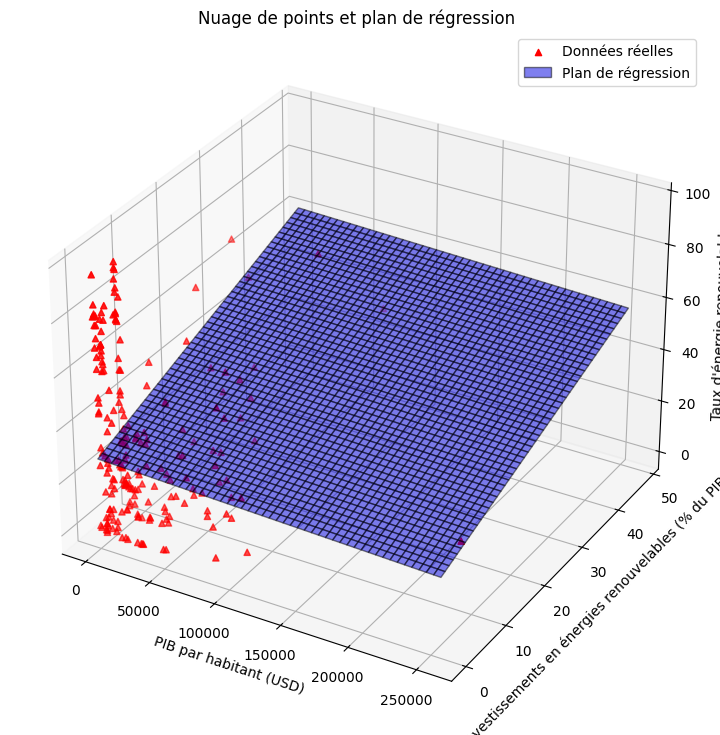

In [75]:
# Préparer les données pour la visualisation (fixer une variable explicative à sa moyenne)
fixed_value = X_train['Accès à l\'électricité (%)'].mean()  # Fixer la variable "Accès à l'électricité (%)"
x1 = np.linspace(X_train['PIB par habitant (USD)'].min(), X_train['PIB par habitant (USD)'].max(), 50)
x2 = np.linspace(X_train['Investissements en énergies renouvelables (% du PIB)'].min(), 
                 X_train['Investissements en énergies renouvelables (% du PIB)'].max(), 50)
x1, x2 = np.meshgrid(x1, x2)
x3_fixed = np.full_like(x1, fixed_value)

# Créer une grille pour les prédictions
X_grid = pd.DataFrame({
    'PIB par habitant (USD)': x1.ravel(),
    'Investissements en énergies renouvelables (% du PIB)': x2.ravel(),
    'Accès à l\'électricité (%)': x3_fixed.ravel()
})
X_grid_scaled = pd.DataFrame(scaler.transform(X_grid), columns=X_train.columns)  # Appliquer la standardisation
X_grid_scaled = sm.add_constant(X_grid_scaled)  # Ajouter l'intercept
y_pred_plane = model.predict(X_grid_scaled).values.reshape(x1.shape)

# Visualisation en 3D
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Nuage de points des données réelles
ax.scatter(X_train['PIB par habitant (USD)'], 
           X_train['Investissements en énergies renouvelables (% du PIB)'], 
           y_train, c='r', marker='^', label="Données réelles")

# Surface de régression
ax.plot_surface(x1, x2, y_pred_plane, alpha=0.5, color='blue', edgecolor='k', label="Plan de régression")

# Étiquettes des axes
ax.set_xlabel('PIB par habitant (USD)')
ax.set_ylabel('Investissements en énergies renouvelables (% du PIB)')
ax.set_zlabel('Taux d\'énergie renouvelable')
ax.set_title('Nuage de points et plan de régression')

plt.legend()
plt.show()

Le graphique montre une visualisation en 3D des données et du modèle de régression obtenu :

1. **Nuage de points (données réelles)** :
   - Les triangles rouges représentent les valeurs réelles des données. 
   - Ces points montrent comment les taux d'énergie renouvelable varient en fonction du PIB par habitant (axe X) et des investissements en énergies renouvelables en pourcentage du PIB (axe Y).

2. **Plan de régression (modèle prédictif)** :
   - Le plan bleu représente la prédiction du modèle de régression.
   - Il montre comment le taux d'énergie renouvelable (axe Z) est influencé par le PIB par habitant et les investissements en énergies renouvelables.

3. **Analyse visuelle** :
   - La majorité des données semblent concentrées dans une région où le PIB par habitant est faible et où les investissements en énergies renouvelables sont modérés.
   - Le plan de régression est relativement plat dans certaines zones, suggérant que l'effet des variables explicatives sur le taux d'énergie renouvelable pourrait être faible ou peu significatif dans ces régions.

## Étape 8 : Tests de régression

#### 1. Test de Durbin-Watson (pour détecter l'autocorrélation des résidus)

In [76]:
# Calcul des résidus du modèle
residuals = model.resid

# Test de Durbin-Watson pour l'autocorrélation des résidus
dw_statistic = durbin_watson(residuals)
print(f"Statistique de Durbin-Watson : {dw_statistic}")

# Interprétation :
# Une statistique proche de 2 indique l'absence d'autocorrélation.
# Une statistique inférieure à 2 suggère une autocorrélation positive.
# Une statistique supérieure à 2 suggère une autocorrélation négative.

Statistique de Durbin-Watson : 2.0510587437321077


Statistique de Durbin-Watson : 2.051 : Cette valeur est proche de 2, ce qui suggère qu'il n'y a pas d'autocorrélation significative des résidus. Les résidus semblent être indépendants.

#### 2. Test de White pour l'Hétéroscédasticité

In [77]:
# Test de White pour l'hétéroscédasticité
white_test_stat, white_p_value, _, _ = het_white(residuals, model.model.exog)

print(f"Statistique de White : {white_test_stat}")
print(f"P-value de White : {white_p_value}")

# Interprétation :
# Si le p-value est supérieur à 0.05, l'hypothèse nulle (absence d'hétéroscédasticité) n'est pas rejetée.
# Si le p-value est inférieur à 0.05, l'hypothèse nulle est rejetée et il y a de l'hétéroscédasticité.

Statistique de White : 13.357494787575003
P-value de White : 0.14708590305671204


- La p-value du test de White est de 0,147, ce qui est supérieur au seuil de 0,05. Par conséquent, nous ne rejetons pas l'hypothèse nulle. Cela indique qu'il n'y a pas d'hétéroscédasticité significative dans le modèle.
- L'absence d'hétéroscédasticité signifie que la variance des résidus est relativement constante à travers les différentes valeurs des variables explicatives. le modèle de régression semble être bien spécifié en termes d'homoscédasticité.

## Étape 8 : Évaluation de la Performance du Modèle de Régression Linéaire Multiple

#### 1. Erreur quadratique moyenne (MSE) et RMSE 

In [78]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_scaled)

# Calcul du MSE
mse = metrics.mean_squared_error(y_test, y_pred)

# Calcul du RMSE
rmse = np.sqrt(mse)

print("MSE :", mse)
print("RMSE :", rmse)

MSE : 281.33942658826555
RMSE : 16.773175805084307


- **MSE (281.34)** : Cela représente la moyenne des carrés des erreurs entre les valeurs réelles (`y_test`) et les valeurs prédites (`y_pred`). Plus le MSE est bas, mieux c'est, car cela indique que les prédictions sont proches des valeurs réelles. Un MSE de 281.34 signifie qu'en moyenne, l'erreur de prédiction est de l'ordre de 281.34 pour le carré des différences. Cependant, comme il est en unités carrées, il est souvent difficile à interpréter directement sans la racine carrée.

- **RMSE (16.77)** : La racine carrée de la MSE donne le RMSE, qui est dans les mêmes unités que la variable cible . Le RMSE de 16.77 indique que, en moyenne, les prédictions s'écartent des valeurs réelles d'environ 16.77 unités. 

- Ces valeurs indiquent que, en moyenne, les prédictions du modèle sont à environ **16.77 unités** (selon les unités de la variable cible) des valeurs réelles.
- Un **MSE de 281.34** et un **RMSE de 16.77** suggèrent que bien que le modèle puisse expliquer une certaine variance des données, il existe encore un écart moyen notable entre les prédictions et les valeurs réelles.

#### 2. Coefficient de détermination (R²)

In [79]:
# Prédictions sur les données de test
y_pred = model.predict(X_test_scaled)

# Calcul du R²
r2 = r2_score(y_test, y_pred)

# Calcul du R² ajusté
n = len(y_test)  # Nombre d'observations
p = X_test_scaled.shape[1]  # Nombre de variables explicatives
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Coefficient de détermination (R²) :", r2)
print("Coefficient de détermination ajusté (R² ajusté) :", r2_adjusted)

Coefficient de détermination (R²) : 0.6169514373932443
Coefficient de détermination ajusté (R² ajusté) : 0.5856821669763663


-Nous avons obtenu un coefficient de détermination \( R^2 = 0.6169 \), ce qui signifie que notre modèle explique environ **61.7%** de la variance totale de \( y \)(`Taux d'énergie renouvelable`). Cela indique que nos variables explicatives (\( X \)) ont un impact significatif sur la prédiction de notre variable cible, ce qui est plutôt encourageant. Un \( R^2 \) supérieur à 0.6 est souvent considéré comme une performance raisonnable.

-En revanche, lorsque nous ajustons ce coefficient pour tenir compte du nombre de variables explicatives et de la taille de l'échantillon, nous obtenons un \( R^2 \) ajusté de **0.5857**. Ce score ajusté est légèrement inférieur au \( R^2 \) brut.

#### 3. P-values des coefficients

In [80]:
# Afficher les coefficients et les p-values
print("Coefficients des variables :")
print(model.params)

print("\nP-values des coefficients :")
print(model.pvalues)

Coefficients des variables :
const                                                   30.877036
PIB par habitant (USD)                                  -0.448172
Investissements en énergies renouvelables (% du PIB)     4.660835
Accès à l'électricité (%)                              -21.006575
dtype: float64

P-values des coefficients :
const                                                   7.141906e-67
PIB par habitant (USD)                                  7.376108e-01
Investissements en énergies renouvelables (% du PIB)    2.263681e-04
Accès à l'électricité (%)                               2.646031e-38
dtype: float64


Les **p-values** des coefficients permettent d'évaluer si chaque variable explicative a un impact statistiquement significatif sur la variable cible (**Taux d'énergie renouvelable**). Voici l'interprétation des résultats :  

##### Résultats :  
- **const (Intercept)** : p-value = **7.14e-67**  
  - Cette p-value extrêmement faible indique que l'intercept est significativement différent de zéro. Cela signifie qu'il y a une valeur de base significative pour le taux d'énergie renouvelable lorsque toutes les variables explicatives sont nulles.  

- **PIB par habitant (USD)** : p-value = **0.7376**  
  - Cette p-value est bien supérieure au seuil commun de 0.05. Cela indique que, pour ce modèle, le **PIB par habitant** n'a pas d'effet statistiquement significatif sur le taux d'énergie renouvelable.

- **Investissements en énergies renouvelables (% du PIB)** : p-value = **2.26e-04**  
  - Cette p-value est bien inférieure à 0.05, ce qui montre que cette variable a un impact significatif sur le taux d'énergie renouvelable. 

- **Accès à l'électricité (%)** : p-value = **2.65e-38**  
  - Cette p-value est extrêmement faible, indiquant un effet très significatif de l'accès à l'électricité sur le taux d'énergie renouvelable. Cette variable est donc très pertinente pour expliquer la variabilité de la cible.  

##### Conclusion :  
- Les **Investissements en énergies renouvelables** et **l'Accès à l'électricité** sont des variables explicatives significatives dans le modèle.  
- Le **PIB par habitant** n'est pas significatif ici, ce qui suggère qu'il contribue peu à la prédiction du taux d'énergie renouvelable.

#### 4. Erreurs résiduelles et Visualisation

##### 4.1- Diagramme des résidus :

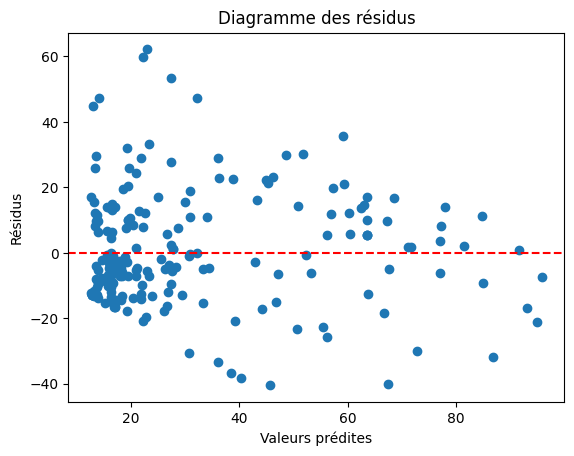

In [81]:
# Graphique des résidus
plt.scatter(model.fittedvalues, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Diagramme des résidus")
plt.show()

1. **Axe horizontal (Valeurs prédites)** :
   - Représente les valeurs prédites par le modèle de régression.

2. **Axe vertical (Résidus)** :
   - Les résidus sont la différence entre les valeurs observées et les valeurs prédites par le modèle.

3. **Ligne horizontale rouge** :
   - Représente la ligne où les résidus sont nuls. 

---


  - Les résidus ne semblent pas être distribués de manière totalement aléatoire. 
  - On observe une plus grande concentration de résidus pour les petites valeurs prédites et une variabilité croissante pour les grandes valeurs.

  - La variabilité des résidus semble augmenter avec les valeurs prédites.

---



##### 4.2- Histogramme des résidus :

- un histogramme des résidus, superposé avec une courbe de distribution normale, afin d'évaluer la normalité des résidus :

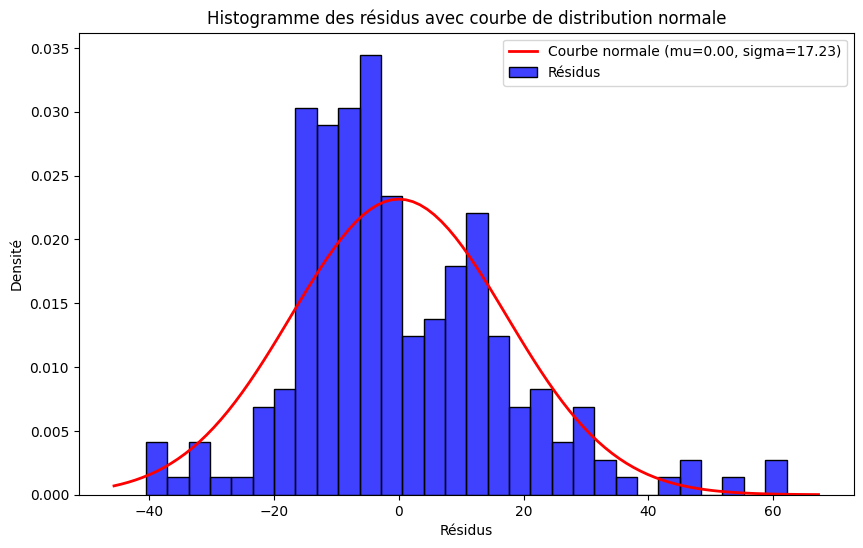

In [82]:
# Calcul des résidus
residuals = model.resid

# Tracer l'histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=False, bins=30, color="blue", label="Résidus", stat="density")

# Ajuster et tracer la courbe de distribution normale
mu, std = norm.fit(residuals)  # Moyenne et écart-type des résidus
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "r", linewidth=2, label="Courbe normale (mu={:.2f}, sigma={:.2f})".format(mu, std))

# Ajouter des annotations
plt.title("Histogramme des résidus avec courbe de distribution normale")
plt.xlabel("Résidus")
plt.ylabel("Densité")
plt.legend()
plt.show()

##### Interprétation de l'histogramme des résidus avec courbe de distribution normale :

1. **Forme générale de l'histogramme** :
   - L'histogramme montre la distribution des résidus (différences entre les valeurs observées et les valeurs prédites).
   - Il semble approximativement symétrique, mais pas parfaitement ajusté à la courbe normale. Cela pourrait indiquer une légère déviation de la normalité.

2. **Courbe de distribution normale (ligne rouge)** :
   - La courbe rouge représente une distribution normale ajustée sur les résidus, avec une moyenne (`mu`) egal 0 et un écart-type (`sigma`) de 17.23.
   - Les résidus devraient idéalement suivre cette courbe si l'hypothèse de normalité est respectée.

3. **Points à remarquer** :
   - **Déviation sur les extrêmes** : Il y a quelques résidus extrêmes dans les queues gauche et droite, ce qui pourrait indiquer des valeurs atypiques ou une légère asymétrie.
   - **Concentration centrale** : La majorité des résidus se trouvent autour de 0, ce qui est cohérent avec un modèle bien ajusté.

4. **Conclusion** :
   - Les résidus montrent une distribution relativement proche d'une normale, mais il existe des signes de déviation, particulièrement dans les queues.
   - Pour valider davantage la normalité des résidus, il serait pertinent d'effectuer un **test statistique de normalité** (comme Shapiro-Wilk) en complément de l'histogramme.

##### 4.3- Test de normalité des résidus (Test de Shapiro-Wilk) :

In [83]:
# Test de normalité des résidus (Shapiro-Wilk)
from scipy import stats
stat, p_value = stats.shapiro(residuals)
print("\nTest de normalité des résidus (Shapiro-Wilk) : p-value =", p_value)


Test de normalité des résidus (Shapiro-Wilk) : p-value = 5.551436367948449e-06


1. **Rappel de l'hypothèse du test de Shapiro-Wilk** :
   - **Hypothèse nulle (H₀)** : Les résidus suivent une distribution normale.
   - **Hypothèse alternative (H₁)** : Les résidus ne suivent pas une distribution normale.

2. **Résultat obtenu** :
   - La **p-value** calculée est de `5.55e-06`(valeur très petite).

3. **Décision** :
   - Si la p-value est **inférieure à 0.05** (niveau de signification standard), on **rejette l'hypothèse nulle**.
   - Ici, la p-value est bien inférieure à 0.05, donc on rejette l'hypothèse selon laquelle les résidus suivent une distribution normale.

4. **Conclusion** :
   - Les résidus **ne suivent pas une distribution normale**.

## Étape 9 : Conclusion

1. **Investissements dans les énergies renouvelables** :  
   Les décideurs politiques devraient augmenter les investissements dans les énergies renouvelables, car ces derniers ont un effet positif et significatif sur leur adoption.

2. **Accès à l'électricité** :  
   L'effet négatif de l'accès à l'électricité peut être lié à la prédominance des sources fossiles dans les réseaux bien développés. Des politiques ciblées pour intégrer davantage de sources renouvelables dans les réseaux existants sont essentielles.

3. **PIB par habitant** :  
   Bien que non significatif, cet indicateur peut être un proxy utile pour classer les pays et adapter les recommandations selon leur niveau de développement économique.

Le modèle met en évidence l'importance des investissements dans les énergies renouvelables tout en soulignant des défis liés à la dépendance des infrastructures énergétiques actuelles. Ces résultats suggèrent que les pays doivent prioriser les investissements et réformer les infrastructures pour faciliter une transition énergétique efficace.